## Data:


#### test_table
Shape: (453321, 9)

Columns:
- user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
- date : when they came to the site for the first time since the test started
- source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
- device : device used by the user. It can be mobile or web
- browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) 
- ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
- browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
- conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
- test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

#### user_table
Shape: (452867, 4)
Columns:
- user_id : the id of the user. It can be joined to user id in the other table 
- sex : user sex: Male or Female
- age : user age (self-reported)
- country : user country based on ip address

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the table
df_test = pd.read_csv("./test_table.csv")
df_user = pd.read_csv("./user_table.csv")

In [3]:
# print some samples
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
# print some samples
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
# merge two tables
df = df_test.merge(df_user, how="left")
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [ ]:
# 懶人包
plt.ion()
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

### 懶人包簡易資訊
- test_table有454筆資料沒有出現在user_table (沒辦法對到他是哪個國家，因此刪除)
- source is highly correlated with ads_channel
- device is highly correlated with browser
- date：2015-11-30 ~ 2015-12-04
- Ads:SEO:Direct = 2:2:1
- browser_language: ES >> EN
- ads_channel: Facebook, Google佔大多數
- test: 實驗組跟對照組的數量不會差太多
- sex: M:F = 3:2
- age: 右尾分布，低年齡層人較多
- country: 17個國家，Mexico >> others

In [29]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           453321 non-null  int64  
 1   date              453321 non-null  object 
 2   source            453321 non-null  object 
 3   device            453321 non-null  object 
 4   browser_language  453321 non-null  object 
 5   ads_channel       181877 non-null  object 
 6   browser           453321 non-null  object 
 7   conversion        453321 non-null  int64  
 8   test              453321 non-null  int64  
 9   sex               452867 non-null  object 
 10  age               452867 non-null  float64
 11  country           452867 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 61.1+ MB


In [86]:
# ref: https://github.com/ShinminHsu/DS-study-group/blob/shinmin_hsu/01_conversion_rate.ipynb
# Note: update seaborn pkg to latest version, or might occur errors.
def plot_conversion_rate_categorical(df, target, control="conversion"):
    
    custom_params = {"axes.spines.top": False, "font.size": 16}
    sns.set_theme(style="ticks", palette="Set2", font_scale=2, rc=custom_params)

    # calculate the conversion rate and the number of users for each target of interest
    total = df.groupby(target)[control].count().reset_index()
    group = df[[target, control]].groupby(target).mean().reset_index()
    order_list = group[target]

    fig, g1 = plt.subplots(figsize=(40, 8))
    g2 = g1.twinx()

    # barplot
    sns.countplot(df, x=target, hue=control, order=order_list, ax=g1)
    g1.set_yscale("log")

    # lineplot: to show conversion rate
    g2.plot(group[target], group[control], color="dimgrey", marker='o', linestyle='dashed',
         linewidth=2, markersize=8)
    if control == "conversion":
        g2.set(ylim=(0, 0.1))

    # annotation
    for i in range(group.shape[0]):
        x = group.iloc[i][target]
        y = group.iloc[i][control]
        label = f"{y*100:.2f}%"

        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color="dimgrey")
        
    # add the number of users for each target of interest to x labels
    labels = [item.get_text() for item in g1.get_xticklabels()]

    labels = [f"{label} \n {total[total[target] == label][control].values[0]:,}" for label in labels]
    g1.set_xticklabels(labels)
    
    fig.text(0.06, 0, 'Note: Numbers under labels are the total number for each label', ha='left', fontsize=20)
    
    plt.title(f"{control} rate by {target}", fontsize=25, pad=40)
    plt.tight_layout()
    plt.show()

<ipython-input-49-fede685f7a30>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


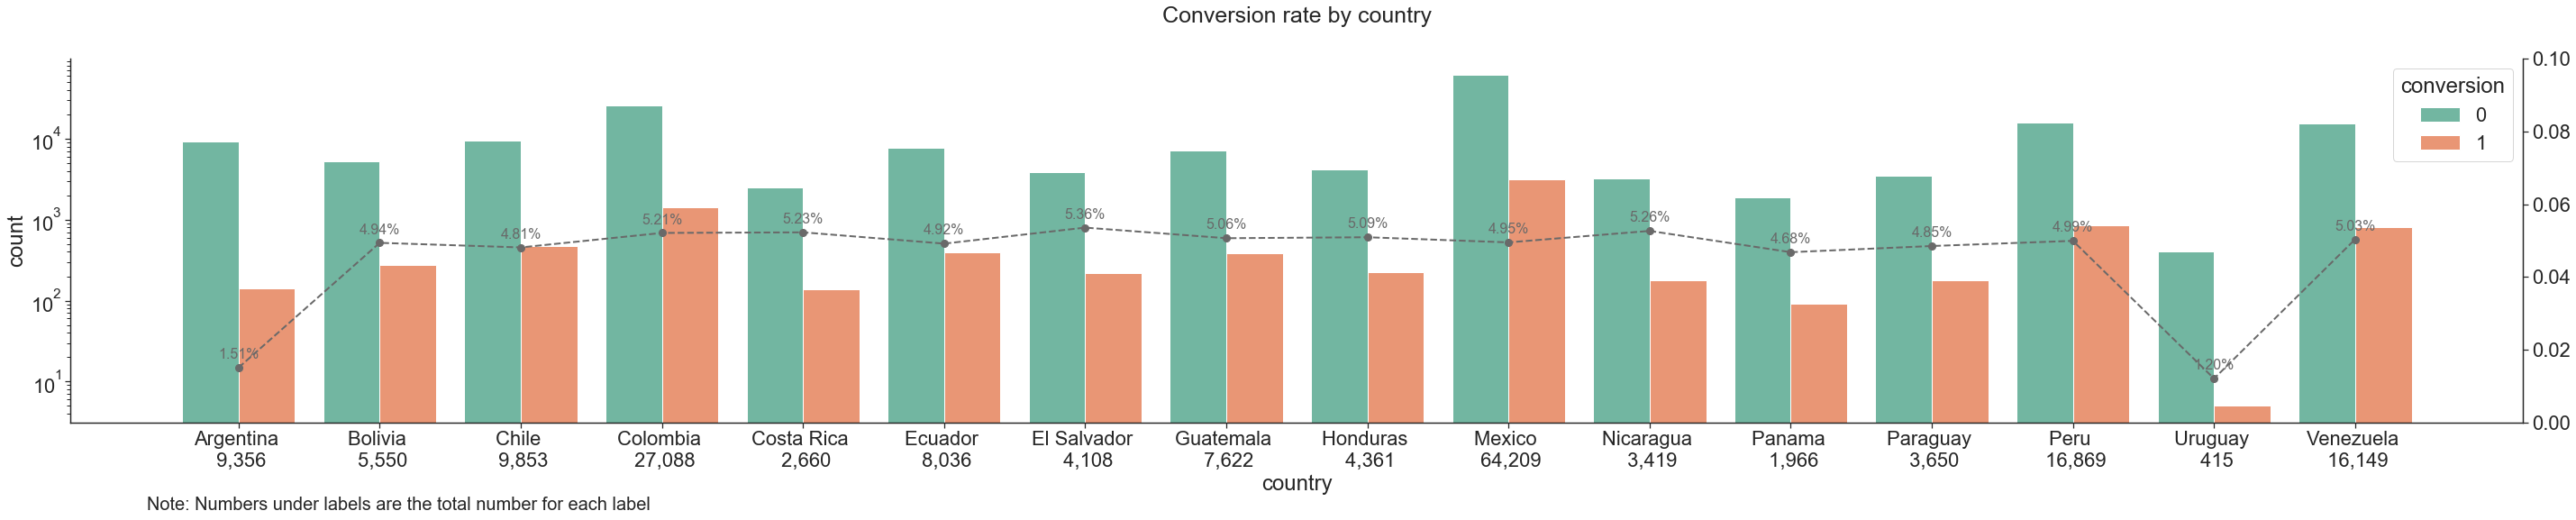

<ipython-input-49-fede685f7a30>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


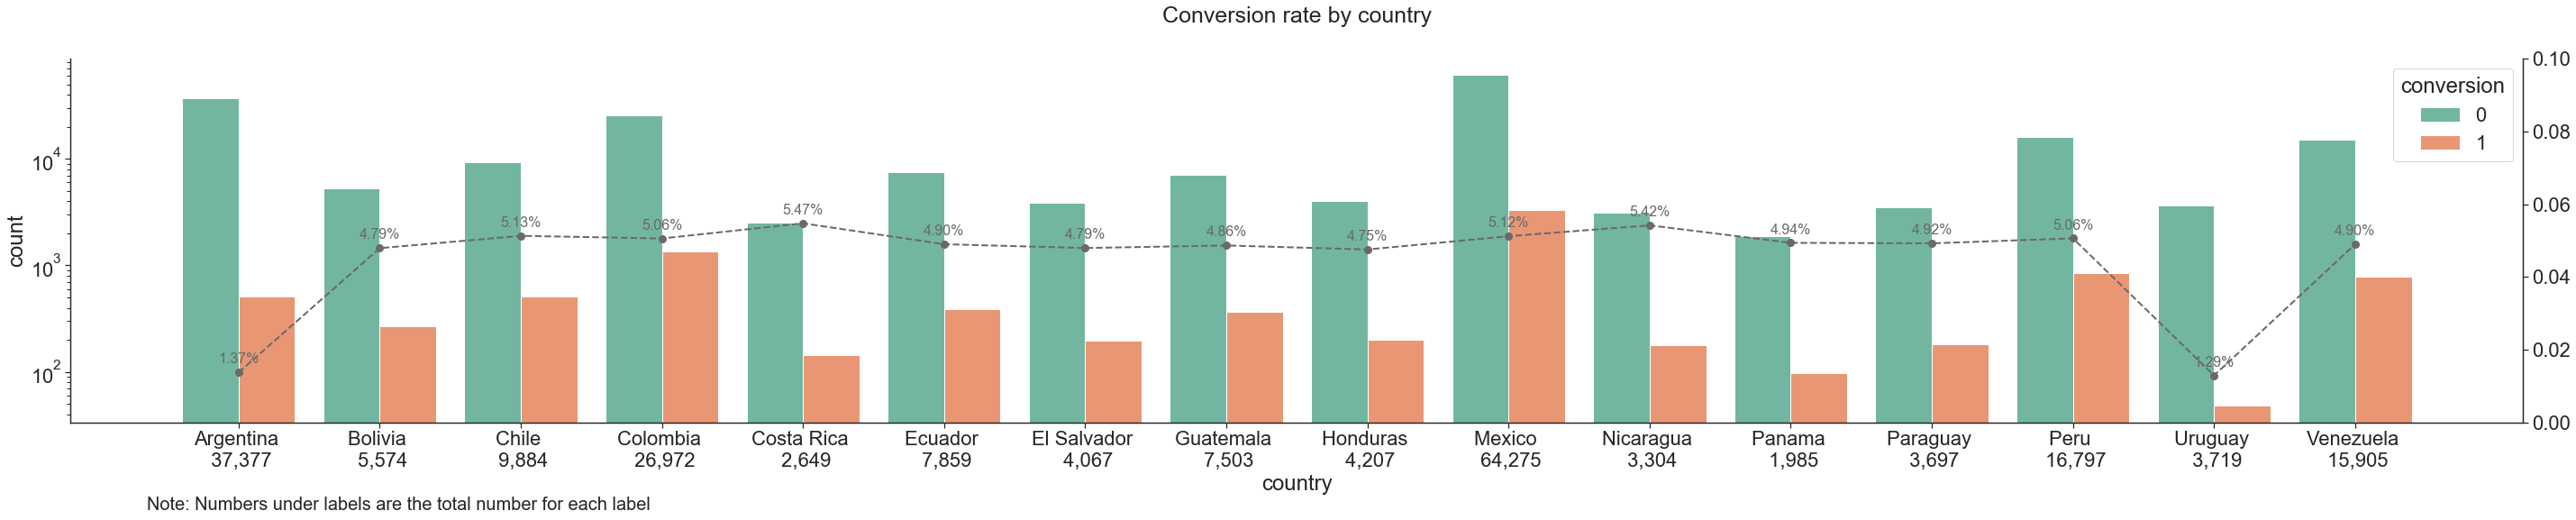

In [53]:
plot_conversion_rate_categorical(df[(df.test == 0)
                                   & (df.country != "Spain")
                                   ], "country")
plot_conversion_rate_categorical(df[(df.test == 1)
                                   & (df.country != "Spain")
                                   ], "country")

<ipython-input-86-d6dd5a2207ef>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(labels)


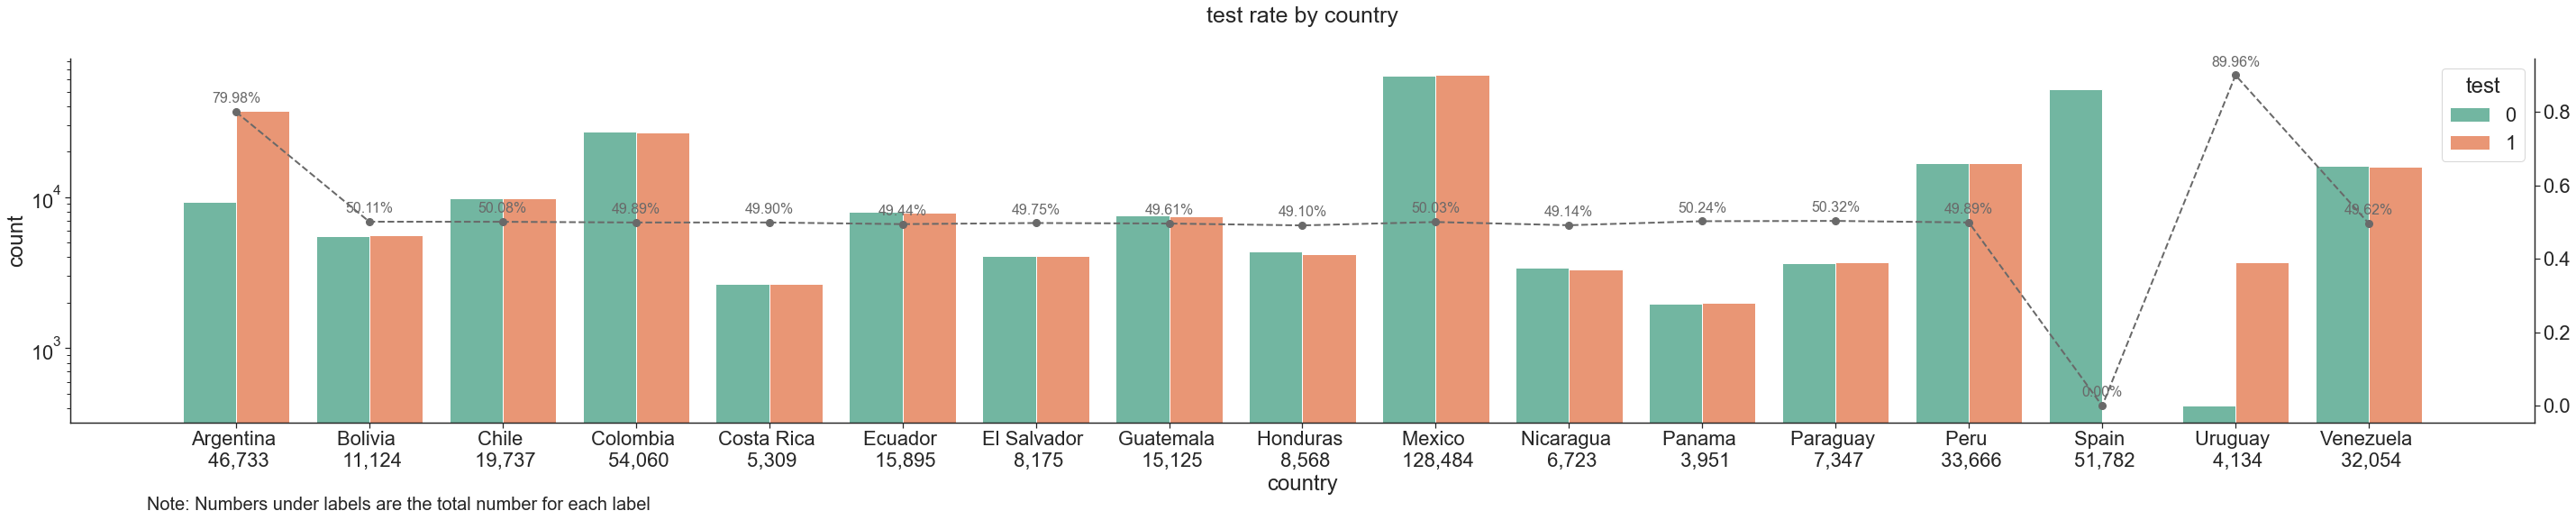

In [87]:
plot_conversion_rate_categorical(df, target="country", control="test")

- Spain 沒有在對照組(test=1)裡
- Chile, Costa Rica, Mexico, Nicaragua, Penama, Paraguay, Peru, Uruguay在實驗組的conversion rate比對照組高
- Argentina, Uruguay的抽樣比例差有點多

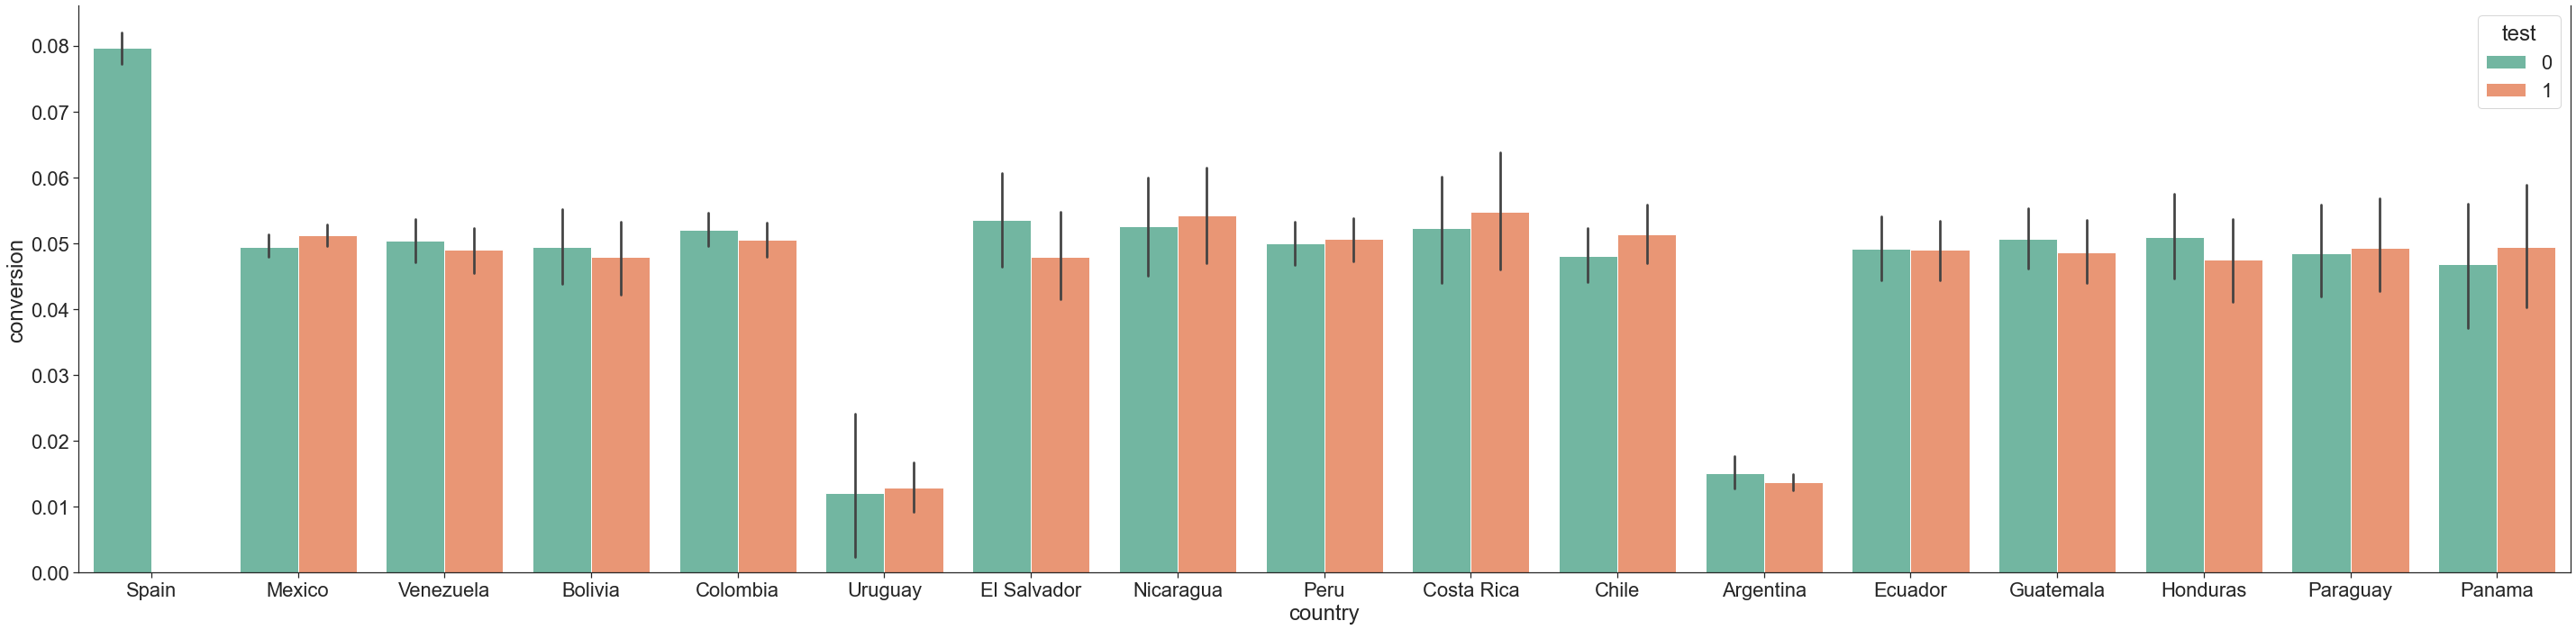

In [68]:
fig,ax=plt.subplots(figsize=(40, 10)) 
sns.barplot(x='country', y='conversion', hue='test', data=df,ax=ax)
plt.tight_layout()
plt.show()

# A/B test

### Naive A/B test

In [27]:
for i in range(2):
    print(f"Coversion Rate for group {i}: {df[df.test == i]['conversion'].sum()/df[df.test == i].shape[0]}")

Coversion Rate for group 0: 0.055178690306651276
Coversion Rate for group 1: 0.043424713982118966


In [28]:
crosstab = pd.crosstab(df['conversion'], df['test'])
crosstab

test,0,1
conversion,,
0,224242,206604
1,13096,9379


In [29]:
stats.chi2_contingency(crosstab)

(331.29412129469165,
 5.022589207281378e-74,
 1,
 array([[225571.12498208, 205274.87501792],
        [ 11766.87501792,  10708.12498208]]))

In [30]:
relative_risk = stats.contingency.relative_risk(
    crosstab.iloc[0, 0], crosstab.iloc[:, 0].sum(), crosstab.iloc[0, 1], crosstab.iloc[:, 1].sum()
)
print(relative_risk.relative_risk)
if relative_risk.confidence_interval().low < 1 and relative_risk.confidence_interval().high > 1:
    print("\033[32m", relative_risk.confidence_interval(), "\033[0m")
else:
    print("\033[31m", relative_risk.confidence_interval(), "\033[0m")

0.9877124398922507
 ConfidenceInterval(low=0.9864056882858424, high=0.9890209226319858) 


### without spain

In [31]:
df_not_spain = df[df.country != "Spain"]

for i in range(2):
    print(f"Coversion Rate for group {i}: {df_not_spain[df_not_spain.test == i]['conversion'].sum()/df_not_spain[df_not_spain.test == i].shape[0]}")

crosstab = pd.crosstab(df_not_spain['conversion'], df_not_spain['test'])
stats.chi2_contingency(crosstab)

Coversion Rate for group 0: 0.04833042316066309
Coversion Rate for group 1: 0.043424713982118966


(54.97395341084682,
 1.2213774388714579e-13,
 1,
 array([[177077.6306959, 206114.3693041],
        [  8478.3693041,   9868.6306959]]))

In [32]:
relative_risk = stats.contingency.relative_risk(
    crosstab.iloc[0, 0], crosstab.iloc[:, 0].sum(), crosstab.iloc[0, 1], crosstab.iloc[:, 1].sum()
)
print(relative_risk.relative_risk)
if relative_risk.confidence_interval().low < 1 and relative_risk.confidence_interval().high > 1:
    print("\033[32m", relative_risk.confidence_interval(), "\033[0m")
else:
    print("\033[31m", relative_risk.confidence_interval(), "\033[0m")

0.9948715911332332
 ConfidenceInterval(low=0.9935161362246931, high=0.9962288952900564) 


### Q1: Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
- 我選擇使用的方式是: Relative Risk (odds ratio也可以，只是scipy裡面剛好只有RR)
    - 若需要更嚴謹的討論，可參考：[為什麼都用「勝算比」odds ratio(OR) 而不是「相對風險」 (RR)呢？](https://chungyizhen.medium.com/%E7%82%BA%E4%BB%80%E9%BA%BC%E9%83%BD%E7%94%A8-%E5%8B%9D%E7%AE%97%E6%AF%94-odds-ratio-or-%E8%80%8C%E4%B8%8D%E6%98%AF-%E7%9B%B8%E5%B0%8D%E9%A2%A8%E9%9A%AA-rr-%E5%91%A2-5c62fe84787c)
    
    - wiki: https://zh.wikipedia.org/zh-hant/%E7%9B%B8%E5%B0%8D%E9%A2%A8%E9%9A%AA
    - package: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.relative_risk.html?highlight=odds%20ratio
    - H0: 實驗組與對照組conversion rate沒有實際差異
    - H1: 實驗組與對照組conversion rate有實際差異
- 如果直接對實驗組(test=1)、對照組(test=0)做檢定，會發現信賴區間不包含1（拒絕虛無假設），且因為relative_risk為0.987，表示對照組的conversion rate是實驗組的0.987倍，因此得到實驗組的效果變差的結論
- 若排除Spain，得到的結果仍舊拒絕虛無假設，且relative_risk為0.994，更接近一點，但仍然得到實驗組效果變差的結論。
    

### Q2: Explain why that might be happening. Are the localized translations really worse?
- 若整個實驗混著做，會很容易拒絕虛無假設
    - 樣本數太大
    - 實驗偏誤，分布不相同
    - 對照組多了Spain（極度偏差的資料集）
- 可以發現把Spain拔掉後，檢定結果有更接近，但因為樣本太大還是拒絕虛無假設，但可以從這個結果發現，其實分開檢定更合理一點
- 所以直接下結論說，這個實驗讓結果變糟糕是不合理的

### Seperate by country

In [33]:
country_index = df.country.value_counts().sort_index().index
for country in country_index:
    if country != "Spain":
        print(f"Country: {country}")
        df_tmp = df[df.country == country]
        for i in range(2):
            print(f"Coversion Rate for group {i}: {df_tmp[df_tmp.test == i]['conversion'].sum()/df_tmp[df_tmp.test == i].shape[0]}")
        crosstab = pd.crosstab(df_tmp['conversion'], df_tmp['test'])
        relative_risk = stats.contingency.relative_risk(
            crosstab.iloc[0, 0], crosstab.iloc[:, 0].sum(), crosstab.iloc[0, 1], crosstab.iloc[:, 1].sum()
        )
        print(relative_risk.relative_risk)
        if relative_risk.confidence_interval().low < 1 and relative_risk.confidence_interval().high > 1:
            print("\033[32m", relative_risk.confidence_interval(), "\033[0m")
        else:
            print("\033[31m", relative_risk.confidence_interval(), "\033[0m")
        print("--------------------------------------------------------------------------------")

Country: Argentina
Coversion Rate for group 0: 0.015070542967079948
Coversion Rate for group 1: 0.013725018059234288
0.9986357507465129
 ConfidenceInterval(low=0.9958662135233708, high=1.0014129901452347) 
--------------------------------------------------------------------------------
Country: Bolivia
Coversion Rate for group 0: 0.04936936936936937
Coversion Rate for group 1: 0.04790096878363832
0.998457722844382
 ConfidenceInterval(low=0.9901023366216728, high=1.006883619433897) 
--------------------------------------------------------------------------------
Country: Chile
Coversion Rate for group 0: 0.048107175479549374
Coversion Rate for group 1: 0.051295022258195065
1.0033602087618785
 ConfidenceInterval(low=0.9969781073667566, high=1.0097831648336644) 
--------------------------------------------------------------------------------
Country: Colombia
Coversion Rate for group 0: 0.052089486119314826
Coversion Rate for group 1: 0.05057096247960848
0.9984005927987285
 ConfidenceInte

### Q3: If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.
- 將國家分開做實驗，可以發現與原先檢定的結論相反！
    - 所有結論變成不顯著（表示不拒絕虛無假設，conversion rate在實驗組跟對照組沒有明顯差異），代表也沒有變好，但也不能得到變差的結論